# Multi_label Emotion Classification
Dataste used: **track-a.csv**

**Imports necessary libraries for the project**

In [ ]:
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import get_linear_schedule_with_warmup, RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, hamming_loss, roc_curve, auc, multilabel_confusion_matrix

/home/navami/.pyenv/versions/env2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


Reads the data from a CSV file `track-a.csv` into pandas DataFrame and all the rows with no emotions are removed.
CSV file has 5 emotions `'anger', 'fear', 'joy', 'sadness', 'surprise'`.

In [3]:
# Read the data from csv file
df = pd.read_csv('track-a.csv')

#class of emotions
label_columns = ['anger', 'fear', 'joy', 'sadness', 'surprise']

# drop rows without any emotion label
df = df[df[label_columns].sum(axis=1) > 0].reset_index(drop=True)


Loaded data is splitted into training(75%), validation(15%), and testing(10%) sets.

In [4]:
#splitting data for train(75%), validation(15%) and test(10%)
train_df, temp_df = train_test_split(df, test_size=0.25, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.40, random_state=42)

train_texts, train_labels = train_df['text'].tolist(), train_df[label_columns].values
val_texts,   val_labels   = val_df['text'].tolist(),   val_df[label_columns].values
test_texts,  test_labels  = test_df['text'].tolist(),  test_df[label_columns].values

In [2]:
#Parameters
tokenizer_name = 'roberta-base' #name of the pre-trained tokenizer(Roberta)
max_len= 128                    # Maximum sequence length for tokenization
batch_size = 16                 # batch size used for training and validaton

lr_encoder= 1e-5      # Learning rate for the encoder part of the model(Roberta)
lr_head = 5e-5        # Learning rate for the classification head

epochs = 10                  # Total number of training epochs
unfreeze_last4_epoch= 1      # Epoch at which to unfreeze the last 4 layers of the encoder
unfreeze_all_epoch = 3       # Epoch at which to unfreeze the entire encoder

#early stopping parameter
best_val_f1 = 0.0             #tracks the best val F1 score
best_val_loss = float('inf')  #tracks the best val loss score
epochs_no_improve = 0         # Counts the number of epochs with no improvement in val loss
patience = 2                  # Number of epochs to wait for improvement before early stopping

Downloads and loads Roberta pre-trained tokenizer.

In [6]:
#define roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained(tokenizer_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

`EmotionDataset` class handles the tokenization of text data and prepares it in a format suitable for training the PyTorch model. Also creates instances of this dataset for the training, validation, and test sets and creates DataLoaders for efficient batching during training and evaluation.


In [7]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels.astype('float32')
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['text'] = self.texts[idx]
        return item



train_dataset= EmotionDataset(train_texts,train_labels, tokenizer, max_len)
val_dataset = EmotionDataset(val_texts,val_labels, tokenizer, max_len)
test_dataset = EmotionDataset(test_texts, test_labels, tokenizer, max_len)

train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

`EmotionClassifier` class uses a pre-trained Roberta model as the encoder and adds a dropout layer and a linear classifier for classifing into 5 labels on top for multi-label classification.

In [8]:
class EmotionClassifier(nn.Module):
    def __init__(self, num_labels=len(label_columns)):
        super().__init__()
        self.bert = RobertaModel.from_pretrained(tokenizer_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids=None, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(outputs.pooler_output)
        return self.classifier(pooled)

Functions for freezing and unfreezing layers of the Roberta model. These functions are used to implement fine-tuning, where different parts of the model are trained with different learning rates and are layers are kept frozen during early stages of training.

In [9]:
def freeze_all(model):
    for p in model.bert.parameters():
        p.requires_grad = False

def unfreeze_last_k_layers(model, k):
    freeze_all(model)
    if k == 0:
        return
    for layer in model.bert.encoder.layer[-k:]:
        for p in layer.parameters():
            p.requires_grad = True

def unfreeze_everything(model):
    for p in model.bert.parameters():
        p.requires_grad = True

Defines
1. loss function: `BCEWithLogitsLoss`
2. optimizer: `AdamW`
3. learning rate scheduler: `get_linear_schedule_with_warmup`

In [10]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = EmotionClassifier().to(device)

# weighted class
# label_counts = train_df[label_columns].sum()
# neg_counts   = len(train_df) - label_counts
# pos_weight   = torch.tensor(neg_counts / label_counts, dtype=torch.float32).to(device)
# criterion    = BCEWithLogitsLoss(pos_weight=pos_weight)
criterion    = BCEWithLogitsLoss()

# Parameter groups for discriminative LR
optimizer = AdamW([
    {"params": model.bert.parameters(), "lr": lr_encoder},
    {"params": model.classifier.parameters(), "lr": lr_head}
], weight_decay=0.01)

total_steps = len(train_loader) * epochs
scheduler   = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# freezing all encoders
freeze_all(model)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training function `run_epoch` performs training or evaluation at each epoch. It iterates through the data loader, performs forward and backward passes (in training mode), calculates the loss, and computes evaluation metrics (macro F1 score and accuracy).

In [11]:
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []
train_f1_hist,  val_f1_hist  = [], []


def run_epoch(model, loader, train_mode=True):
    if train_mode:
        model.train()
    else:
        model.eval()
    total_loss, all_preds, all_labels = 0.0, [], []

    for batch in tqdm(loader, leave=False):
        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        labels    = batch['labels'].to(device)

        with torch.set_grad_enabled(train_mode):
            outputs = model(input_ids, attn_mask)
            loss    = criterion(outputs, labels)
            if train_mode:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

        total_loss += loss.item()
        all_preds.append(torch.sigmoid(outputs).detach().cpu())
        all_labels.append(labels.cpu())

    preds = torch.vstack(all_preds)
    labels = torch.vstack(all_labels)
    preds_bin = (preds > 0.5).int()
    macro_f1 = f1_score(labels, preds_bin, average='macro')
    exact_acc = np.mean((preds_bin.numpy() == labels.numpy()).all(axis=1))

    return total_loss / len(loader), macro_f1, exact_acc


**Training loop** \
It iterates through the 10 epochs, implements the unfreezing schedule for the model layers, calls the `run_epoch` function for training and validation, tracks loss and train, val metrics, and implements early stopping based on validation loss. It also saves the model with the best validation F1 score.

In [12]:
for epoch in range(epochs):
    # Unfreezing schedule
    if epoch == unfreeze_last4_epoch:
        unfreeze_last_k_layers(model, 4)
    if epoch == unfreeze_all_epoch:
        unfreeze_everything(model)

    print(f"Epoch {epoch+1}/{epochs}")
    tr_loss, tr_f1, tr_acc,  = run_epoch(model, train_loader, train_mode=True)
    vl_loss, vl_f1, vl_acc = run_epoch(model, val_loader, train_mode=False)

    train_loss_hist.append(tr_loss)
    val_loss_hist.append(vl_loss)
    train_acc_hist.append(tr_acc)
    val_acc_hist.append(vl_acc)
    train_f1_hist.append(tr_f1)
    val_f1_hist.append(vl_f1)

    print(f"Train loss={tr_loss:.4f} | Train acc: {tr_acc:.4f} | Train F1={tr_f1:.4f} | Val F1={vl_f1:.4f} | Val acc={vl_acc:.4f} | Val loss={vl_loss:.4f}\n")

    # Early stopping logic
    train_stop = False
    if vl_loss < best_val_loss:
        best_val_loss = vl_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epochs.")
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            train_stop = True

    # save best model by val_F1
    if vl_f1 > best_val_f1:
        best_val_f1 = vl_f1
        torch.save(model.state_dict(), 'bert_emotion_best.pt')
        tokenizer.save_pretrained("bert_emotion_best/")

    if train_stop:
        break

print(f"Training finished with best validation macro‑F1: {best_val_f1:.4f}")

Epoch 1/10


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss=0.6637 | Train acc: 0.0744 | Train F1=0.3648 | Val F1=0.1527 | Val acc=0.1557 | Val loss=0.6373

Epoch 2/10


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss=0.5873 | Train acc: 0.1693 | Train F1=0.1563 | Val F1=0.1527 | Val acc=0.1557 | Val loss=0.5803

Epoch 3/10


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss=0.5139 | Train acc: 0.2331 | Train F1=0.3274 | Val F1=0.5229 | Val acc=0.3799 | Val loss=0.4385

Epoch 4/10


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss=0.3996 | Train acc: 0.4214 | Train F1=0.6052 | Val F1=0.6574 | Val acc=0.4459 | Val loss=0.3757

Epoch 5/10


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss=0.3276 | Train acc: 0.5021 | Train F1=0.7236 | Val F1=0.7212 | Val acc=0.4776 | Val loss=0.3446

Epoch 6/10


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss=0.2782 | Train acc: 0.5812 | Train F1=0.7960 | Val F1=0.7189 | Val acc=0.4644 | Val loss=0.3484

No improvement in validation loss for 1 epochs.
Epoch 7/10


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Train loss=0.2446 | Train acc: 0.6176 | Train F1=0.8331 | Val F1=0.7108 | Val acc=0.4565 | Val loss=0.3456

No improvement in validation loss for 2 epochs.
Early stopping triggered.
Training finished with best validation macro‑F1: 0.7212


After training, got a best validation accuracy of 47% and F1 score of 72%

Function defined to calculate the `hamming score`

In [2]:
def hamming_score(y_true, y_pred):

    acc_list = []
    for i in range(y_true.shape[0]):
        true_set = set(np.where(y_true[i] == 1)[0])
        pred_set = set(np.where(y_pred[i] == 1)[0])

        if len(true_set) == 0 and len(pred_set) == 0:
            acc_list.append(1) # if both empty->perfect match
        else:
            acc_list.append(len(true_set & pred_set) / len(true_set | pred_set))

    return np.mean(acc_list)

In [15]:
model.load_state_dict(torch.load('bert_emotion_best.pt'))
model.eval()

def evaluate(loader):
    true, pred = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            labels    = batch['labels']
            outputs   = model(input_ids, attn_mask)
            probs     = torch.sigmoid(outputs).cpu()
            pred.append((probs > 0.5).int())
            true.append(labels)
    return torch.vstack(true), torch.vstack(pred)

true_test, pred_test = evaluate(test_loader)

print("Test metrics:")
print("Accuracy:", accuracy_score(true_test, pred_test))
print("Macro F1:", f1_score(true_test, pred_test, average='macro'))
print("Precision:", precision_score(true_test, pred_test, average='macro'))
print("Recall:", recall_score(true_test, pred_test, average='macro'))
print('Hamming score:', hamming_score(true_test, pred_test))
print("Hamming loss:", hamming_loss(true_test, pred_test))
print("Classification Report:",classification_report(true_test, pred_test, target_names=label_columns))


Test metrics:
Accuracy: 0.4763779527559055
Macro F1: 0.7399485507134286
Precision: 0.7732406201080645
Recall: 0.7123150627118421
Hamming score: 0.6978346456692913
Hamming loss: 0.15748031496062992
Classification Report:               precision    recall  f1-score   support

       anger       0.68      0.58      0.62        33
        fear       0.84      0.88      0.86       168
         joy       0.72      0.70      0.71        61
     sadness       0.83      0.67      0.74       113
    surprise       0.80      0.73      0.77        90

   micro avg       0.80      0.75      0.78       465
   macro avg       0.77      0.71      0.74       465
weighted avg       0.80      0.75      0.78       465
 samples avg       0.81      0.78      0.77       465



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Plot train-Val accuracy, Loss, ROC curve and F1 graphs

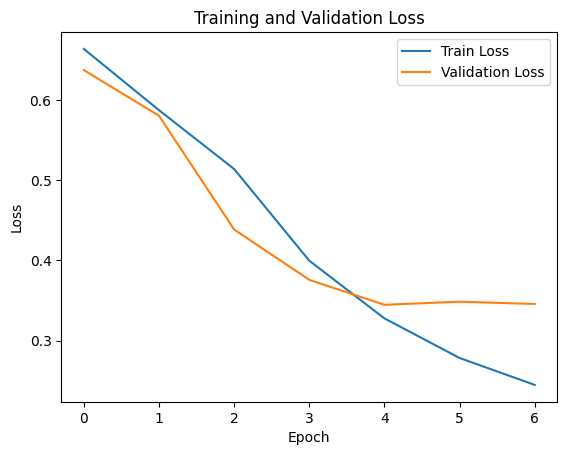

In [16]:
#Plot train-val loss
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


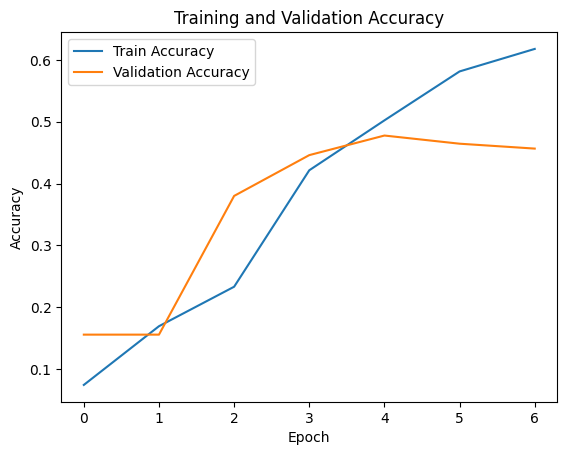

In [17]:
#plot train-val accuracy
plt.plot(train_acc_hist, label='Train Accuracy')
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

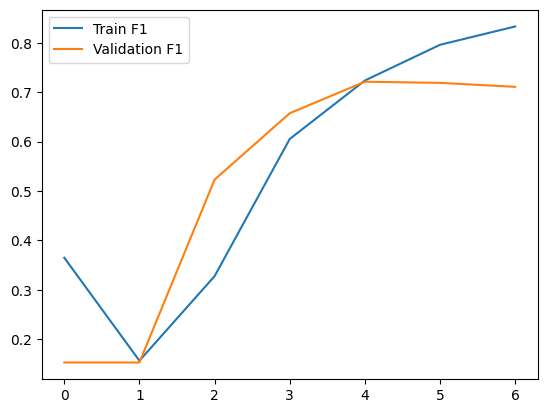

In [18]:

#plot F1 score for train-val
plt.plot(train_f1_hist, label='Train F1')
plt.plot(val_f1_hist, label='Validation F1')
plt.legend()

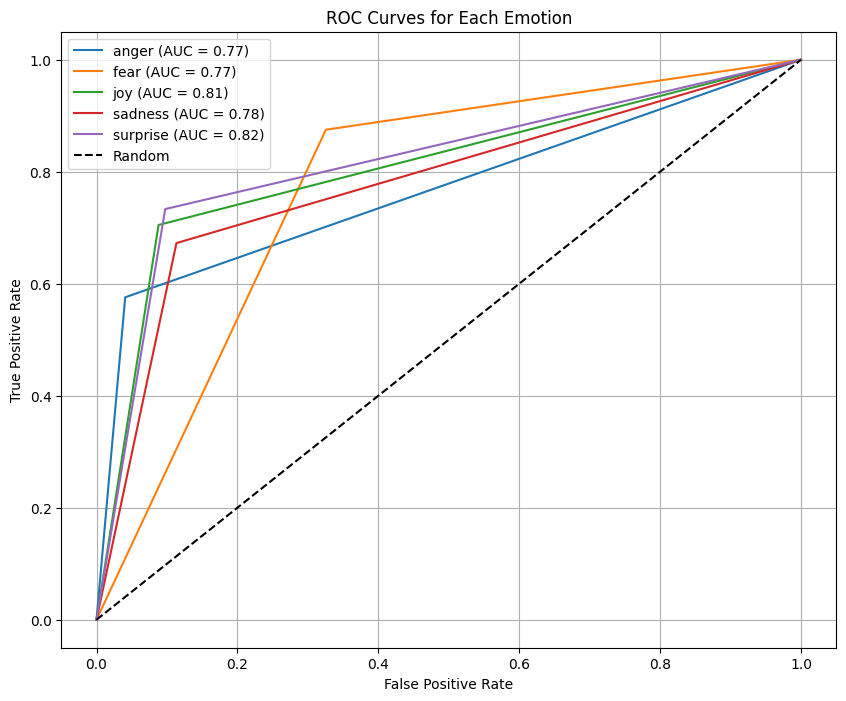

In [19]:

# Calculate ROC curve and AUC for each emotions
roc_data = {}
for i, label in enumerate(label_columns):
    fpr, tpr, thresholds = roc_curve(true_test[:, i], pred_test[:, i])
    roc_auc = auc(fpr, tpr)
    roc_data[label] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

# Plot
plt.figure(figsize=(10, 8))
for label, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], label=f'{label} (AUC = {data["auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Emotion')
plt.legend()
plt.grid(True)
plt.show()

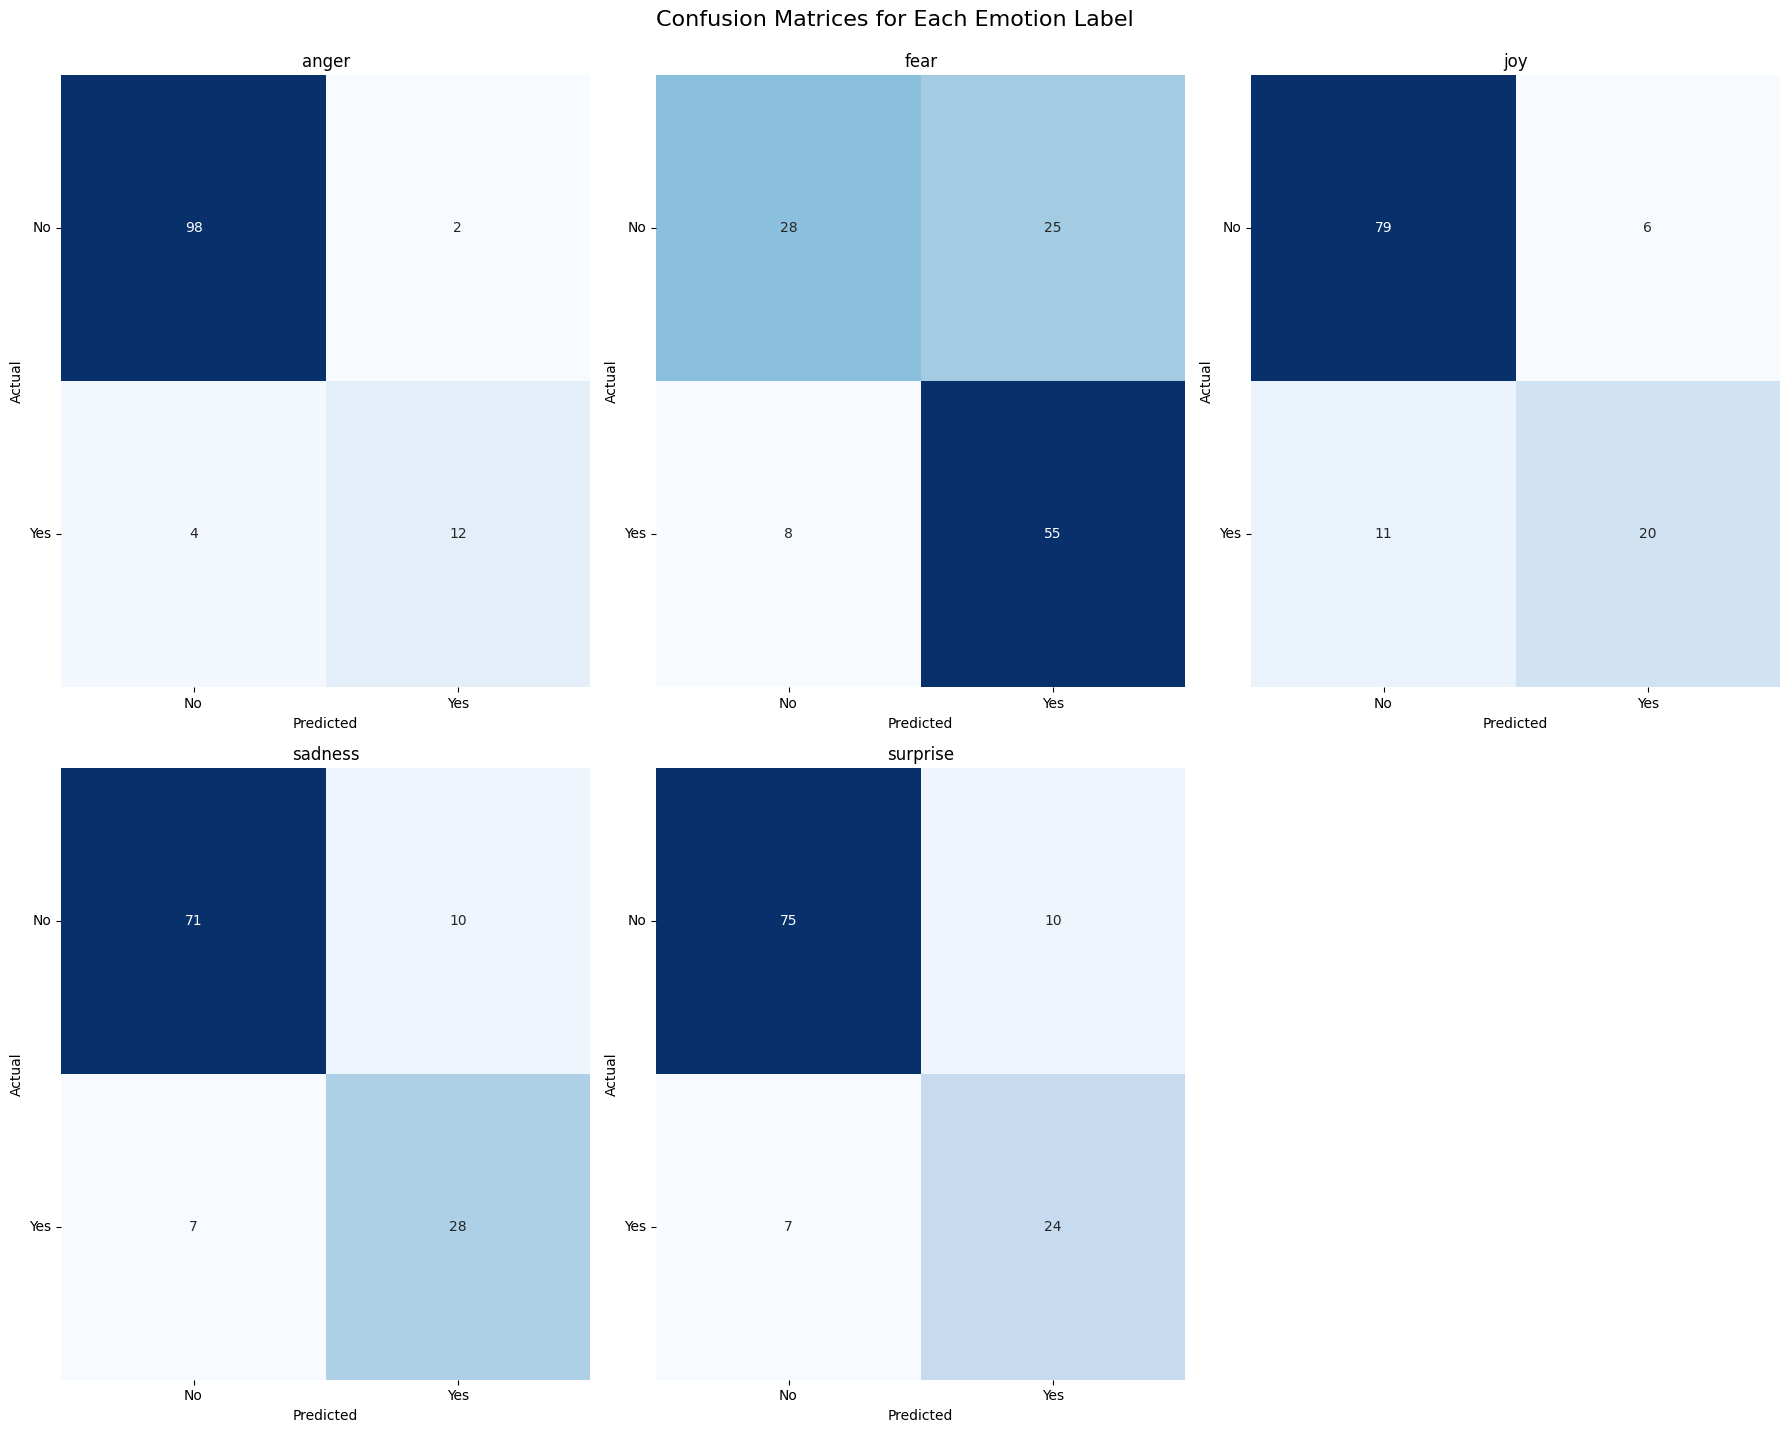

In [ ]:
conf_matrices = multilabel_confusion_matrix(true_test, pred_test)

fig, axes = plt.subplots(2, 3, figsize=(18, 14))  
axes = axes.flatten()

#compute confusion matrix for each label
for i, label in enumerate(label_columns):
    cm = conf_matrices[i]
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'{label}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_yticklabels(['No', 'Yes'], rotation=0)

# Hide the extra subplot if label count < total subplots
if len(label_columns) < len(axes):
    for j in range(len(label_columns), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Confusion Matrices for Each Emotion Label', fontsize=16, y=1.02)
plt.show()

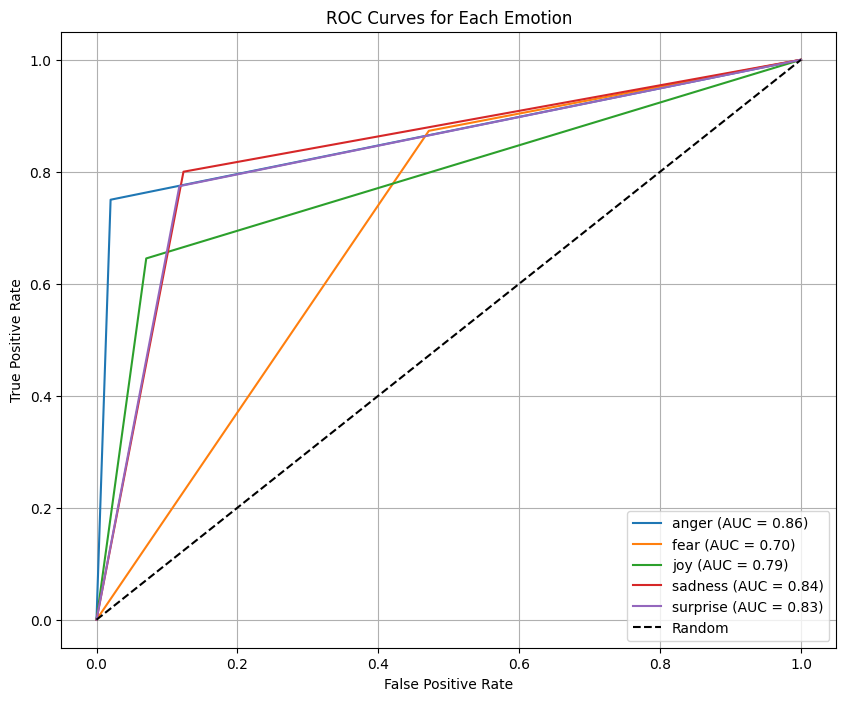

In [19]:

# Calculate ROC curve and AUC for each emotions
roc_data = {}
for i, label in enumerate(label_cols):
    fpr, tpr, thresholds = roc_curve(true_test[:, i], pred_test[:, i])
    roc_auc = auc(fpr, tpr)
    roc_data[label] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

# Plot
plt.figure(figsize=(10, 8))
for label, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], label=f'{label} (AUC = {data["auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Emotion')
plt.legend()
plt.grid(True)
plt.show()